Step: 0, Loss: 2450.017822265625, Accuracy: 0.140625
Step: 100, Loss: 308.2523498535156, Accuracy: 0.6953125
Step: 200, Loss: 258.68792724609375, Accuracy: 0.734375
Step: 300, Loss: 136.54747009277344, Accuracy: 0.84765625
Step: 400, Loss: 146.3819122314453, Accuracy: 0.8828125
Step: 500, Loss: 123.82737731933594, Accuracy: 0.8671875
Step: 600, Loss: 138.57801818847656, Accuracy: 0.8515625
Step: 700, Loss: 113.33828735351562, Accuracy: 0.875
Step: 800, Loss: 119.50142669677734, Accuracy: 0.8828125
Step: 900, Loss: 105.66798400878906, Accuracy: 0.859375
Step: 1000, Loss: 111.04358673095703, Accuracy: 0.8828125
Step: 1100, Loss: 82.04499053955078, Accuracy: 0.91796875
Step: 1200, Loss: 102.58932495117188, Accuracy: 0.87890625
Step: 1300, Loss: 103.25431823730469, Accuracy: 0.87890625
Step: 1400, Loss: 69.40762329101562, Accuracy: 0.9140625
Step: 1500, Loss: 83.769775390625, Accuracy: 0.88671875
Step: 1600, Loss: 82.64495086669922, Accuracy: 0.90234375
Step: 1700, Loss: 66.7252197265625, 

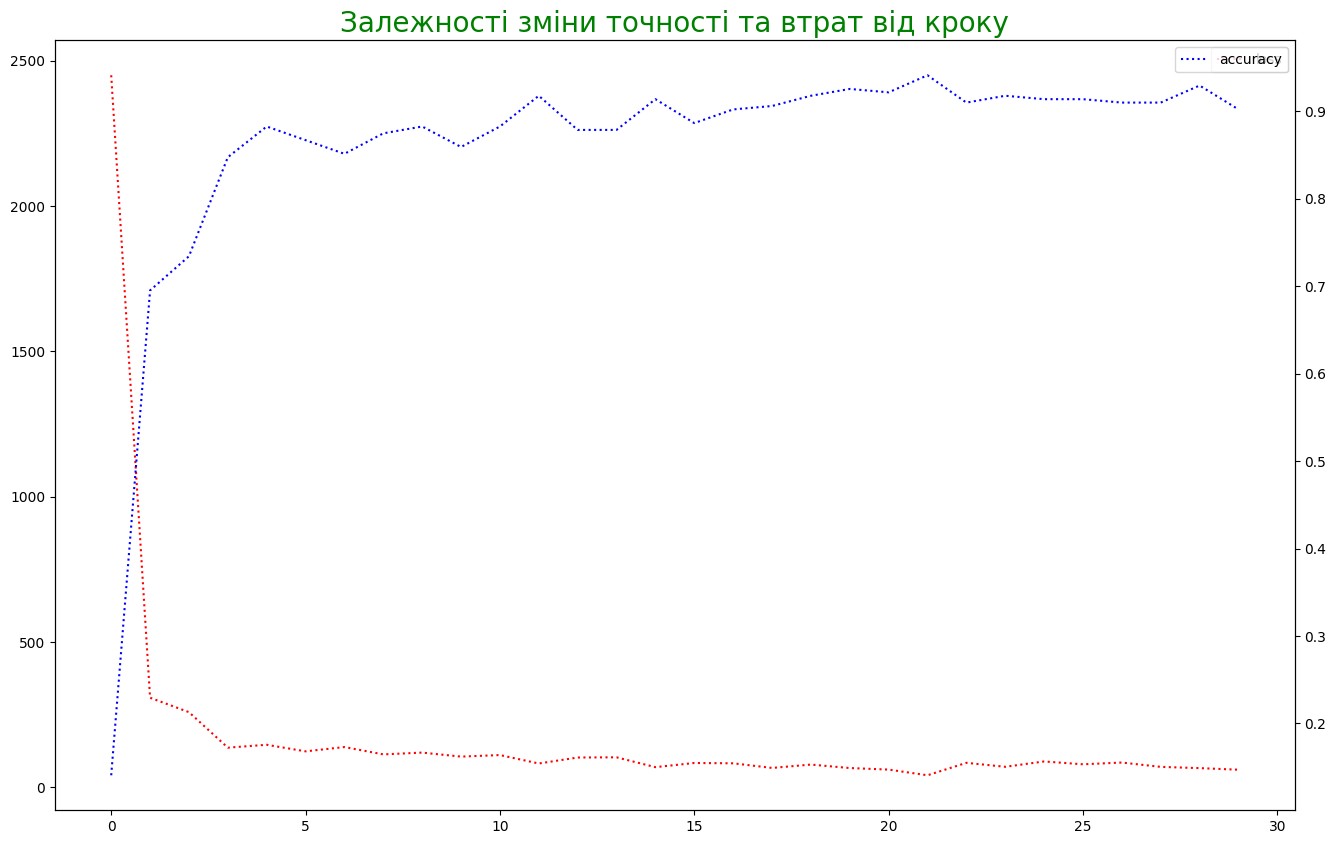

Accuracy: 0.9227499961853027
True: 8 Predict: 8 True
True: 2 Predict: 6 False
True: 2 Predict: 2 True
True: 8 Predict: 8 True
True: 6 Predict: 6 True
True: 6 Predict: 6 True
True: 6 Predict: 6 True
True: 1 Predict: 1 True
True: 5 Predict: 5 True
True: 8 Predict: 8 True


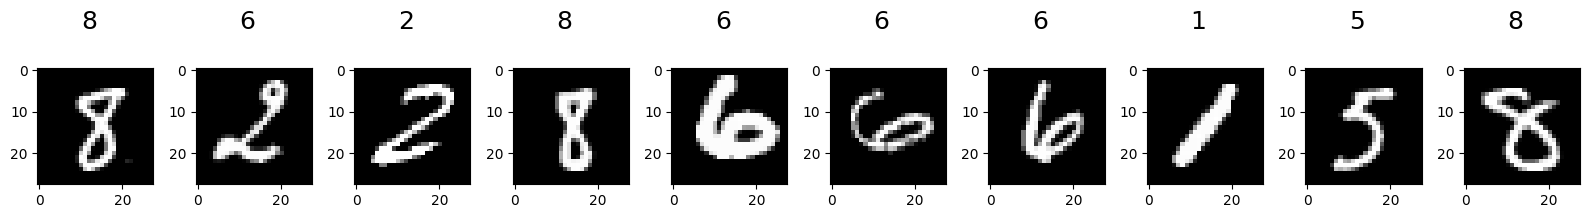

IndexError: ignored

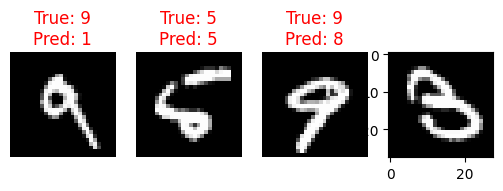

In [3]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
num_classes = 10
num_features = 784
learning_rate = 0.001
training_steps = 3000
batch_size = 256
display_step = 100
n_hidden_1 = 128
n_hidden_2 = 256
from tensorflow.keras.datasets import mnist


(x_train, y_train), (x_test, y_test) = mnist.load_data()


x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)


x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])


x_train, x_test = x_train / 255., x_test / 255.


train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)


class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)

    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)

    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)

    self.layer_3 = DenseLayer(in_features=n_hidden_2, out_features=num_classes)

  def __call__(self, x):

    x1 = self.layer_1(x, activation=0)
    x2 = self.layer_2(x1, activation=0)
    x3 = self.layer_3(x2, activation=1)


    return x3

def cross_entropy(y_pred, y_true):

    y_true = tf.one_hot(y_true, depth=num_classes)


    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)


    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))


def accuracy(y_pred, y_true):

    acc = tf.metrics.Accuracy()
    acc.update_state(y_true, tf.argmax(y_pred, axis=1))
    return acc.result()

neural_net = NN(name="mnist")


def train(nn, input_x, output_y):

  optimizer = tf.optimizers.SGD(learning_rate)

  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)


    trainable_variables = nn.trainable_variables


    gradients = g.gradient(loss, trainable_variables)


    optimizer.apply_gradients(zip(gradients, trainable_variables))


loss_history = []
accuracy_history = []

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps)):

    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        current_loss = cross_entropy(pred, batch_y)
        loss_history.append(current_loss)

        current_accuracy = accuracy(pred, batch_y)
        accuracy_history.append(current_accuracy)
        print(f"Step: {step}, Loss: {current_loss}, Accuracy: {current_accuracy}")

import pandas as pd

fig, axs = plt.subplots(figsize=(16, 10))
axs.plot(loss_history, 'r', label='loss', linestyle=":")
axs.legend()

axs2=axs.twinx()
axs2.plot(accuracy_history, 'b', label='accuracy', linestyle=":")
plt.legend()

plt.title('Залежності зміни точності та втрат від кроку', fontsize=20, color='g')
plt.show()

neural_net_accuracy = accuracy(neural_net(x_train), y_train)
print(f"Accuracy: {neural_net_accuracy}")

test_img = np.random.permutation(x_test.shape[0])[:10]
y_test_true = y_test[test_img]
pred_data = [np.argmax(x) for x in neural_net(x_test[test_img])]

plt.figure(figsize=(16, 6))
for i in range(10):
    print(f"True: {y_test_true[i]} Predict: {pred_data[i]} {True if y_test_true[i] - pred_data[i] == 0 else False}")
    plt.subplot(1, 10, (i + 1))
    plt.imshow(x_test[test_img[i]].reshape(28, 28), cmap='gray')
    plt.text(x=10, y=-10, s=pred_data[i], fontsize=18)

plt.tight_layout()
plt.show()

# Вивести 10 помилково розпізнаних зображень
incorrectly_predicted_indices = []

for i, (img, true_label) in enumerate(zip(x_test, y_test)):
    img = np.reshape(img, (1, num_features))
    pred = neural_net(img)
    pred_label = np.argmax(pred)

    if pred_label != true_label:
        incorrectly_predicted_indices.append(i)

    if len(incorrectly_predicted_indices) == 10:
        break

plt.figure(figsize=(16, 6))
for i, idx in enumerate(incorrectly_predicted_indices):
    plt.subplot(1, 10, (i + 1))
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f"True: {y_test[idx]}\nPred: {pred_data[idx]}", color='red')
    plt.axis('off')

plt.tight_layout()
plt.show()
